In [31]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [32]:

path=str(pathlib.Path().resolve())+"/"

In [33]:
df=pd.read_csv(path+"Intel_Market.csv")
df

,Fecha,Cerrar/último,Volumen,Abrir,Alto,Bajo
0,03/04/2024,"40,33",83717980,"41,40","41,65","40,22"
1,02/04/2024,"43,94",32748360,"43,925","44,08","43,50"
2,01/04/2024,"44,52",31712590,"44,29","45,41","44,18"
3,28/03/2024,"44,17",54204190,"43,76","44,60","43,71"
4,27/03/2024,"43,77",51017830,"42,54","43,83","42,50"
...,...,...,...,...,...,...
2511,10/04/2014,"26,425",40390460,"27,01","27,09","26,36"
2512,09/04/2014,"26,98",34467000,"26,93","27,02","26,73"
2513,08/04/2014,"26,91",56564370,"26,36","26,98","26,35"
2514,07/04/2014,"26,485",49693490,"26,30","26,74","26,20"


In [34]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y').dt.date
df = df.set_index("Fecha")
df['Cerrar/último'] = df['Cerrar/último'].str.replace(",",".").astype(np.float32)
#df = df[['Cerrar/último']].rolling(7).mean().dropna()
df=df[['Cerrar/último']]

In [35]:
#plt.plot(df['Fecha'],df['Cerrar/último'])

In [36]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0,1))
df_transformed = scaler.fit_transform(df)

In [37]:
X = df_transformed[:-1]
y = df_transformed[1:]

In [38]:
X

array([[0.35414284],
       [0.43699795],
       [0.45030993],
       ...,
       [0.04773927],
       [0.04613268],
       [0.03637826]], dtype=float32)

In [39]:
#from sklearn.preprocessing import LabelEncoder

#l = LabelEncoder()
#X = l.fit_transform(X)

In [40]:
from sklearn.model_selection import train_test_split

value = int(len(X)*0.2)
X_train_full, y_train_full, X_test, y_test = X[value:],y[value:],X[:value],y[:value]
X_train, y_train, X_val, y_val = X_train_full[value:],y_train_full[value:],X_train_full[:value],y_train_full[:value]

In [41]:
import numpy as np


#X_train = np.reshape(X_train, (X_train.shape[0], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], 1))

# Red de una Neurona

In [42]:
"""OJO CON EL RETURN_SEQUENCES"""
import sys


def modelo_red_recurrente_3(x_train, y_train,n_neuronas,x_val,y_val):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=sys.maxsize,validation_data=[x_val,y_val],callbacks=[early_stopping_cb])
    return model

In [43]:
from sklearn.metrics import mean_squared_error


modelo = modelo_red_recurrente_3(X_train, y_train,40,X_val,y_val)
y_pred = modelo.predict(X_test)

rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")

Epoch 1/9223372036854775807


48/48 [==============================] - 1s 3ms/step - loss: 0.0296 - val_loss: 0.0086
Epoch 2/9223372036854775807
48/48 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 8.3878e-04
Epoch 3/9223372036854775807
48/48 [==============================] - 0s 1ms/step - loss: 4.2243e-04 - val_loss: 8.0988e-04
Epoch 4/9223372036854775807
48/48 [==============================] - 0s 1ms/step - loss: 4.1679e-04 - val_loss: 8.7279e-04
Epoch 5/9223372036854775807
48/48 [==============================] - 0s 1ms/step - loss: 4.1948e-04 - val_loss: 8.4975e-04
Epoch 6/9223372036854775807
48/48 [==============================] - 0s 1ms/step - loss: 4.2220e-04 - val_loss: 8.0387e-04
Epoch 7/9223372036854775807
48/48 [==============================] - 0s 966us/step - loss: 4.1576e-04 - val_loss: 8.8366e-04
Epoch 8/9223372036854775807
48/48 [==============================] - 0s 976us/step - loss: 4.1660e-04 - val_loss: 8.7259e-04
Epoch 9/9223372036854775807
48/48 [=================

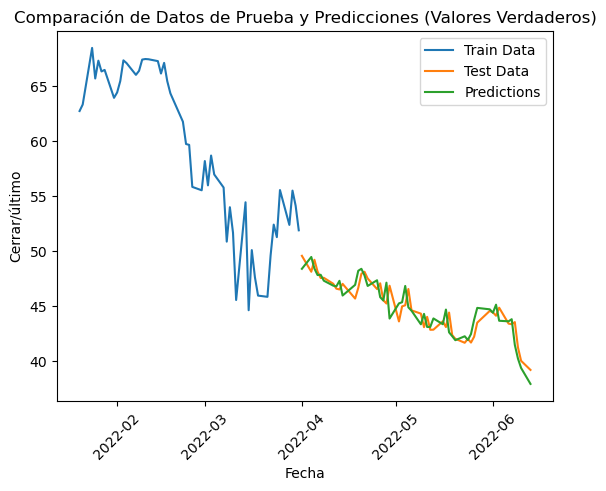

In [44]:
import matplotlib.pyplot as plt

# Concatenar los índices de train y test para plotear
index_train = df.index[len(X_test):][:50]
index_test = df.index[:len(X_test)][-50:]

# Invertir la transformación de MinMaxScaler para obtener los valores verdaderos
y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Plot de datos de entrenamiento
plt.plot(index_train, y_train_inverse[:50], label='Train Data')

# Plot de datos de prueba
plt.plot(index_test, y_test_inverse[-50:], label='Test Data')

# Plot de predicciones
plt.plot(index_test, y_pred_inverse[-50:], label='Predictions')

plt.title('Comparación de Datos de Prueba y Predicciones (Valores Verdaderos)')
plt.xlabel('Fecha')
plt.ylabel('Cerrar/último')
plt.legend()
plt.xticks(rotation=45)
plt.show()



In [45]:
rnn_predice_1_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.Dense(10)
    ])
rnn_predice_1_10.compile(loss="mse", optimizer="adam")
rnn_predice_1_10.fit(X_train, y_train, epochs=100)

Epoch 1/100
48/48 [==============================] - 1s 754us/step - loss: 0.0881
Epoch 2/100
48/48 [==============================] - 0s 736us/step - loss: 0.0511
Epoch 3/100
48/48 [==============================] - 0s 684us/step - loss: 0.0478
Epoch 4/100
48/48 [==============================] - 0s 703us/step - loss: 0.0475
Epoch 5/100
48/48 [==============================] - 0s 751us/step - loss: 0.0471
Epoch 6/100
48/48 [==============================] - 0s 735us/step - loss: 0.0474
Epoch 7/100
48/48 [==============================] - 0s 776us/step - loss: 0.0473
Epoch 8/100
48/48 [==============================] - 0s 769us/step - loss: 0.0471
Epoch 9/100
48/48 [==============================] - 0s 730us/step - loss: 0.0472
Epoch 10/100
48/48 [==============================] - 0s 695us/step - loss: 0.0471
Epoch 11/100
48/48 [==============================] - 0s 655us/step - loss: 0.0472
Epoch 12/100
48/48 [==============================] - 0s 674us/step - loss: 0.0474
Epoch 13/100
